In [69]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
cd /content/drive/MyDrive/AI-2025-study

/content/drive/MyDrive/AI-2025-study


In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
import pandas as pd

df = pd.read_csv("data/twitter_disaster_tweets.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [73]:
df = df.drop(columns=['keyword', 'location'])
df = df.rename(columns={'target': 'label'})

In [74]:
df.isnull().sum()

,0
id,0
text,0
label,0


In [75]:
df = df.sample(frac=1).reset_index(drop=True)

In [76]:
df.head()

,id,text,label
0,10224,@MrMikeEaton @Muazimus_Prime hill hill mountai...,1
1,3086,Cancers equate for around 25% of all deaths in...,1
2,6247,The Murderous Story Of AmericaÛªs First Hijac...,1
3,3602,The date for the release of EP03 DESOLATION is...,1
4,1987,On holiday to relax sunbathe and drink ... Put...,0


In [77]:
df['label'].value_counts()

,count
label,
0,4342
1,3271


<Axes: >

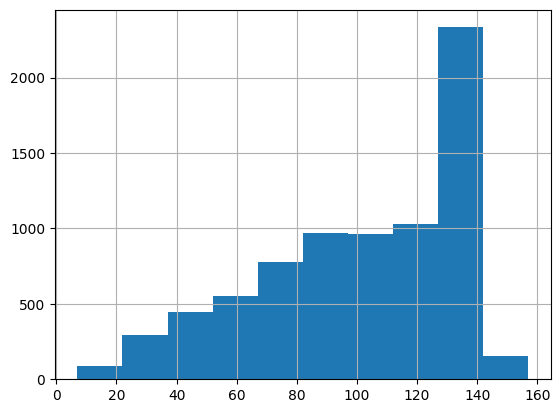

In [78]:
df['text'].str.len().hist()

### Data loading with huggingface

In [79]:
!pip install datasets

In [80]:
from datasets import Dataset

In [81]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(0.2)


In [82]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 1523
    })
})

In [83]:
dataset['train'][1]

{'id': 2831,
 'text': 'BBC Forced To Retract False Claims About Cyclone Pam http://t.co/ciHC8Nrc9h via @wordpressdotcom',
 'label': 1}

In [84]:
id2labels = {
    0: 'general',
    1: 'disaster'
}

labels2id = {
    'general': 0,
    'disaster': 1
}

### Data tokenization

In [85]:
from transformers import AutoTokenizer
import torch

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# custom_cache_dir = "D:/app/llm-model"
model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

In [87]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [88]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=300)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [89]:
dataset['train'][0]

{'id': 848,
 'text': '#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/wvExJjRG6E',
 'label': 1,
 'input_ids': [101,
  1001,
  2088,
  7349,
  10288,
  2053,
  2936,
  2000,
  3665,
  16012,
  3334,
  29165,
  16216,
  10867,
  2015,
  1999,
  5256,
  1997,
  14405,
  13492,
  2595,
  6845,
  28616,
  3270,
  4523,
  8299,
  1024,
  1013,
  1013,
  1056,
  1012,
  2522,
  1013,
  1059,
  3726,
  2595,
  3501,
  3501,
  10623,
  2575,
  2063,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

### Model evaluation
https://huggingface.co/docs/transformers/en/tasks/sequence_classification#evaluate

In [90]:
!pip install evaluate

In [91]:
import evaluate
import numpy as np

In [92]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [93]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


In [94]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels2id),
    label2id=labels2id,
    id2label=id2labels,
    # cache_dir=custom_cache_dir
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [96]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer

)

In [97]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.489049,0.774787
2,No log,0.440384,0.809586
3,0.464800,0.434326,0.812213
4,0.464800,0.446722,0.807617
5,0.464800,0.446479,0.814839


TrainOutput(global_step=955, training_loss=0.4157142838882526, metrics={'train_runtime': 102.6188, 'train_samples_per_second': 296.729, 'train_steps_per_second': 9.306, 'total_flos': 71633368245600.0, 'train_loss': 0.4157142838882526, 'epoch': 5.0})

In [98]:
trainer.evaluate()

{'eval_loss': 0.44647887349128723,
 'eval_accuracy': 0.81483913328956,
 'eval_runtime': 2.3394,
 'eval_samples_per_second': 651.019,
 'eval_steps_per_second': 20.518,
 'epoch': 5.0}

### Model save and load for inference

In [99]:
trainer.save_model('tinybert-disaster-tweet')

In [102]:

data = [
    'There is a fire in the building',
    'I am happy today', 'I am sad today',
    'I am not feeling well',
    'There is a flood in the city, go to higher ground'
]

In [100]:
from transformers import pipeline

In [103]:
classifier = pipeline('text-classification', model='tinybert-disaster-tweet', device='cuda')
classifier(data)

Device set to use cuda


[{'label': 'disaster', 'score': 0.9310268759727478},
 {'label': 'general', 'score': 0.9414865970611572},
 {'label': 'general', 'score': 0.9288975596427917},
 {'label': 'general', 'score': 0.9365766644477844},
 {'label': 'disaster', 'score': 0.9251160025596619}]

### Push model to S3


In [1]:
import boto3

In [2]:
import logging
import boto3
from botocore.exceptions import ClientError
import os
s3 = boto3.client('s3')

def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """

    # Create bucket
    if(bucket_exist(bucket_name)):
        try:
            if region is None:
                s3_client = boto3.client('s3')
                s3_client.create_bucket(Bucket=bucket_name)
            else:
                s3_client = boto3.client('s3', region_name=region)
                location = {'LocationConstraint': region}
                s3_client.create_bucket(Bucket=bucket_name,
                                        CreateBucketConfiguration=location)
        except ClientError as e:
            logging.error(e)
            return False
        return True
    else:
        return False

def bucket_exist(bucket_name):
    response = s3.list_buckets()
    buckets = [bucket['Name'] for bucket in response['Buckets']]
    if bucket_name not in buckets:
        return True
    else:
        print("Bucket is already created!!")
        return False


In [3]:
bucket_name = 'mlops-anansupercute'
region = 'ap-southeast-1'
create_bucket(bucket_name=bucket_name, region=region)

Bucket is already created!!


False

In [4]:
# Retrieve the list of existing buckets
s3 = boto3.client('s3')
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  mlops-anansupercute


In [ ]:
def upload_directory(directory_path, s3_prefix): 
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/") 
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/") 
            s3.upload_file(file_path, bucket_name, s3_key)
            
upload_directory('tinybert-disaster-tweet', 'ml-models/tinybert-disaster-tweet')